In [1]:
import os
import sys
os.chdir('/home/csy/work/3D/PharDiff')
sys.path.append("/home/csy/work/3D/PharDiff/utils")
sys.path.append("/home/csy/work/3D/PharDiff")
import argparse
import multiprocessing as mp
import pickle
import shutil
from functools import partial
from tqdm.auto import tqdm
from utils.data import PDBProtein, parse_sdf_file
from mol_tree import *
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from openbabel import pybel
from openbabel import openbabel as ob
import subprocess
import os
import numpy as np
import shutil
from plip.structure.preparation import PDBComplex
import traceback
import utils.misc as misc
import utils.transforms as trans
from torch_geometric.transforms import Compose
from models.diffusion import PharDiff, log_sample_categorical
from scripts.sample_diffusion import sample_diffusion_ligand
#from pl_data import ProteinLigandData, torchify_dict
import argparse
import multiprocessing as mp
import pickle
import shutil
from functools import partial
from tqdm.auto import tqdm
from utils.data import PDBProtein, parse_sdf_file
from mol_tree import *
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from openbabel import pybel
from openbabel import openbabel as ob
import subprocess
import os
import numpy as np
import shutil
from plip.structure.preparation import PDBComplex
import traceback
import utils.misc as misc
import utils.transforms as trans
from torch_geometric.transforms import Compose
from models.diffusion import PharDiff, log_sample_categorical
from scripts.sample_diffusion import sample_diffusion_ligand
import argparse
import os, sys
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
import torch
from tqdm.auto import tqdm
from glob import glob
from collections import Counter

from utils.evaluation import eval_atom_type, scoring_func, analyze, eval_bond_length
from utils import misc, reconstruct, transforms
from utils.evaluation.docking_qvina import QVinaDockingTask
from utils.evaluation.docking_vina import VinaDockingTask
from datasets.pl_data import ProteinLigandData, torchify_dict
import argparse
import os, sys
sys.path.append("/home/csy/work/3D/PharDiff")
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
import torch
from tqdm.auto import tqdm
from glob import glob
from collections import Counter

from utils.evaluation import eval_atom_type, scoring_func, analyze, eval_bond_length
from utils import misc, reconstruct, transforms
from utils.evaluation.docking_qvina import QVinaDockingTask
from utils.evaluation.docking_vina import VinaDockingTask

In [6]:
# sample_path = '/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19'
# results_fn_list = glob(os.path.join(sample_path, '*result_*.pt'))
results_fn_list = ['/home/csy/work/3D/PharDiff/outputs_2023_11_06__16_04_28/result_0.pt'
]
whole = []
for r_name in results_fn_list:
    pocket_smi = []
    r = torch.load(r_name)
    print(r)
    
    #BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf

{'data': ProteinLigandData(
  protein_element=[409],
  protein_molecule_name='pocket',
  protein_pos=[409, 3],
  protein_is_backbone=[409],
  protein_atom_name=[409],
  protein_atom_to_aa_type=[409],
  protein_atom2residue=[409],
  ligand_smiles='CN(CC[C@H](N)CC(=O)N[C@H]1CC[C@H](N2C=C[C@@](N)(O)NC2=O)O[C@@H]1C(=O)O)C(=N)N',
  ligand_element=[31],
  ligand_pos=[31, 3],
  ligand_bond_index=[2, 64],
  ligand_bond_type=[64],
  ligand_center_of_mass=[3],
  ligand_atom_feature=[31, 8],
  ligand_hybridization=[31],
  amino_acid=[53],
  res_idx=[53],
  center_of_mass=[53, 3],
  pos_CA=[53, 3],
  pos_C=[53, 3],
  pos_N=[53, 3],
  pos_O=[53, 3],
  IntramolInteraction=[7],
  ligand_nbh_list={
    0=[3],
    1=[2],
    2=[2],
    3=[3],
    4=[3],
    5=[2],
    6=[3],
    7=[3],
    8=[1],
    9=[2],
    10=[4],
    11=[2],
    12=[2],
    13=[1],
    14=[1],
    15=[1],
    16=[1],
    17=[3],
    18=[2],
    19=[3],
    20=[1],
    21=[2],
    22=[3],
    23=[1],
    24=[2],
    25=[2],
    26

In [179]:
sample_path = '/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19'
results_fn_list = glob(os.path.join(sample_path, '*result_*.pt'))
results_fn_list = ['/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19/result_0.pt',
                   '/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19/result_1.pt',
                   '/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19/result_2.pt',
                   '/home/csy/work/3D/PharDiff/outputs_2023_10_18__14_15_19/result_3.pt'
]
whole = []
for r_name in results_fn_list[:5]:
    pocket_smi = []
    r = torch.load(r_name)
    print("=================================================")
    print(r['data']['ligand_smiles'])
    pocket_smi.append(Chem.MolFromSmiles(r['data']['ligand_smiles']))
    for ind in range(len(r['pred_ligand_pos'])):
        try:
            pred_pos = r['pred_ligand_pos'][ind]
            pred_v = r['pred_ligand_v'][ind]
            pred_aromatic = transforms.is_aromatic_from_index(pred_v, mode='add_aromatic')
            pred_atom_type = transforms.get_atomic_number_from_index(pred_v, mode='add_aromatic')
            mol = reconstruct.reconstruct_from_generated(pred_pos, pred_atom_type, pred_aromatic)
            smiles = Chem.MolToSmiles(mol)
            if '.' in smiles:
                continue
            print(smiles)
            
            pocket_smi.append(Chem.MolFromSmiles(smiles))
        except:
            continue
    whole.append(pocket_smi)
  

CN(CC[C@H](N)CC(=O)N[C@H]1CC[C@H](N2C=C[C@@](N)(O)NC2=O)O[C@@H]1C(=O)O)C(=N)N
COc1cc(OC)c(S(=O)(=O)NCc2ccccc2N2CCCCC2)cc1NC(C)=O
CC(=O)NC1=CC(S(O)(O)CNCN(O)CC2CCCN(c3ccccc3)C2)C=CC1
Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@](N)(=O)O)[C@@H](O)[C@H]1O
C=C(C)C(C(CC=C1C=NC=NC1=N)OCCO)C(F)C(O)P(N)(O)(O)O
N=C1N=CN=CC1C1=CC(C(CCOP(N)(=O)O)C(O)CNCCO)CC1


[22:20:55] Explicit valence for atom # 30 F, 2, is greater than permitted
[22:20:55] Explicit valence for atom # 30 F, 2, is greater than permitted
[22:20:55] Explicit valence for atom # 18 O, 3, is greater than permitted
[22:20:55] Explicit valence for atom # 19 Cl, 2, is greater than permitted
[22:20:55] Explicit valence for atom # 20 F, 2, is greater than permitted


Nc1cc(S(O)(O)O)c(N)c2c1C(=O)c1ccccc1C2=O
CC(O)C1C(NC2C=CC=CC2)CC2C(C(C)CC=N)NC21
CCCCCCC1CCC(O)CC=C(C2C=CC=CC2Cl)C1
CC(CO)C1C(CCC2NCC2F)NC1NC1C=CC=CC1
COCCNC(=O)C(N)C(C)OC(=O)CCC1=CCC=CC1
CNCC(C)C(CC1C=CC=CC1)C1CC2CCC2CC1O
O=CC(=O)N=CC1(F)CCCC(C(O)Cc2ccccc2)N1
CC(C)OC(N)CC(CCC(N)C(F)=CN)C1C=CC=CC1
CN(CN)OC(CNC(F)OO)N(C)C(=O)c1ccccc1
C=C(C(O)OCC)N(NCCC1CCCC1)C1=CCC=CC1


[22:20:55] Explicit valence for atom # 18 F, 2, is greater than permitted


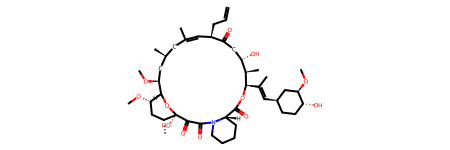

In [96]:
#import Chem
Chem.MolFromSmiles('C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC')


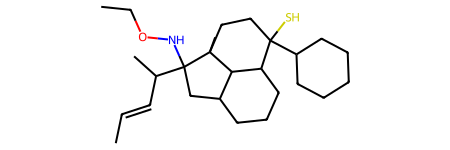

In [69]:
Chem.MolFromSmiles('CC=CC(C)C1(NOCC)CC2CCCC3C2C1(C)CCC3(S)C1CCCCC1')

In [30]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
import rdkit
from rdkit.Chem import Draw
from PIL import Image
from io import BytesIO

from rdkit.Chem import Draw, PandasTools
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#mol = Chem.SDMolSupplier('/home/csy/work/3D/PharDiff/scripts/PDGFRb/data/ligand.sdf')
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
import rdkit
from rdkit.Chem import Draw
from PIL import Image
from io import BytesIO

#Draw.MolsToGridImage(whole[0])

In [109]:
IPythonConsole.drawMol3D(whole[6][5])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
sample_path = '/home/csy/work/3D/PharDiff/outputs_PINN'
results_fn_list = glob(os.path.join(sample_path, '*result_*.pt'))
# results_fn_list = ['/home/csy/work/3D/PharDiff/outputs_2023_10_18__16_18_55/result_0.pt',
#                    '/home/csy/work/3D/PharDiff/outputs_2023_10_18__16_18_55/result_1.pt',
#                    '/home/csy/work/3D/PharDiff/outputs_2023_10_18__16_18_55/result_2.pt',
#                    '/home/csy/work/3D/PharDiff/outputs_2023_10_18__16_18_55/result_3.pt'
# ]

whole_ = []
for r_name in results_fn_list:
    pocket_smi = []
    r = torch.load(r_name)
    #print("=================================================")
    #print(r['data']['ligand_smiles'])
    pocket_smi.append(Chem.MolFromSmiles(r['data']['ligand_smiles']))
    for ind in range(len(r['pred_ligand_pos'])):
        try:
            pred_pos = r['pred_ligand_pos'][ind]
            pred_v = r['pred_ligand_v'][ind]
            pred_aromatic = transforms.is_aromatic_from_index(pred_v, mode='add_aromatic')
            pred_atom_type = transforms.get_atomic_number_from_index(pred_v, mode='add_aromatic')
            mol = reconstruct.reconstruct_from_generated(pred_pos, pred_atom_type, pred_aromatic)
            smiles = Chem.MolToSmiles(mol)
            if '.' in smiles:
                continue
            #print(smiles)
            
            pocket_smi.append(mol)
        except:
            continue
    whole_.append(pocket_smi)

In [86]:
whole_[10][0]
IPythonConsole.drawMol3D(whole_[52][4])
#IPythonConsole.drawMol3D(Chem.MolFromSmiles(smi))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

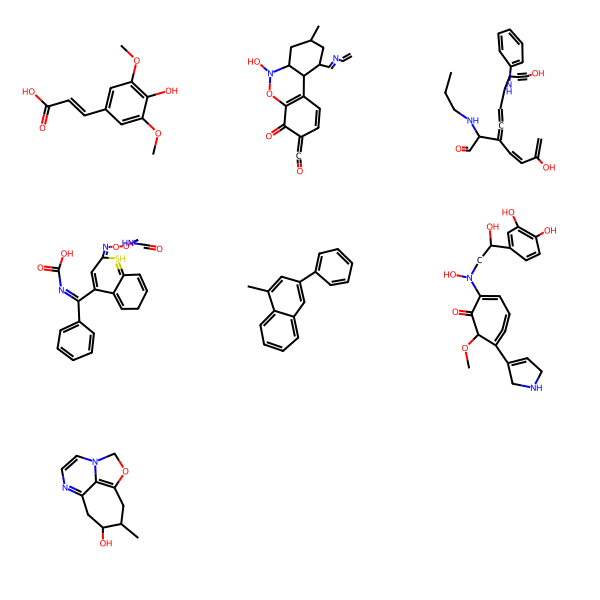

In [101]:
Draw.MolsToGridImage(whole_[24])

In [3]:
Draw.MolsToGridImage(whole_[46])

NameError: name 'Draw' is not defined

In [198]:
from rdkit.Chem import Draw, PandasTools
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

mol = Chem.SDMolSupplier('/home/csy/work/3D/PharDiff/scripts/PDGFRb/data/ligand.sdf')
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
import rdkit
from rdkit.Chem import Draw
from PIL import Image
from io import BytesIO
Draw.MolsToGridImage(mol)
IPythonConsole.drawMol3D(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol